In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BATCH_SIZE = 2

IMG_SIZE = 515

MASK_SIZE = 512

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

NUM_TEST_IMAGES = 1602

# Load data

In [3]:
abs_path = %pwd

In [4]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

In [5]:
DATA_DIR = abs_path + '/data/processed'

In [6]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

Parameters of image changed by dataset authors during augmentation:

1. hue  X
2. saturation  X
3. grayscale 
4. contrast  X
5. brightness  X
6. sharpness X
7. adding noise
8. doing flipping  X
9. rotation  X
10. cropping  X
11. padding

In [7]:
@tf.function
def augmentation(input_image, input_mask):
    
    # random crop and resize
    if tf.random.uniform(()) > 0.5:
        
        crop_size = np.random.randint(420, 490, dtype=int)
        
        input_image = tf.image.random_crop(input_image, size=(crop_size, crop_size, 3))
        input_image = tf.image.resize(input_image, [IMG_SIZE, IMG_SIZE])
        
        input_mask = tf.image.resize(input_mask, [IMG_SIZE, IMG_SIZE])
        input_mask = tf.image.random_crop(input_mask, size=(crop_size, crop_size, 1))
        input_mask = tf.image.resize(input_mask, [MASK_SIZE, MASK_SIZE])
        
    # random hue
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_hue(input_image, 0.2)
    
    # random saturation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_saturation(input_image, 5, 10)
    
    # sharpness (image quality decrease)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_jpeg_quality(input_image, 75, 95)
        input_image = tf.reshape(input_image, (IMG_SIZE, IMG_SIZE,3))
        
    # random brightness adjustment illumination
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_brightness(input_image, 0.3)
    
    # random contrast adjustment
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_contrast(input_image, 0.2, 0.5)
    
    # random horizontal flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    # random vertical flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    # rotation in 30° steps
    if tf.random.uniform(()) > 0.5:
        rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
        angle = np.pi/12*rot_factor
        input_image = tfa.image.rotate(input_image, angle)
        input_mask = tfa.image.rotate(input_mask, angle)
    
    return input_image, input_mask

In [8]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (MASK_SIZE, MASK_SIZE, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[MASK_SIZE, MASK_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def load_augmented_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = augmentation(image, mask)
    return image, mask


def data_generator(image_list, mask_list, augmentation=False):
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    
    if augmentation:
        dataset = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    else:
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


def get_augmented_dataset(image_list, mask_list, factor=1):
    
    dataset = data_generator(image_list, mask_list, augmentation=True)

    for _ in range(factor):

        dataset_to_concat = data_generator(image_list, mask_list, augmentation=True)

        dataset = dataset.concatenate(dataset_to_concat)

    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))


Train Dataset: <BatchDataset shapes: ((2, 515, 515, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7470
Val Dataset: <BatchDataset shapes: ((2, 515, 515, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1602


# Class balance 

In [9]:
# class_count = {
#     0: 0.0,
#     1: 0.0,
#     2: 0.0,
#     3: 0.0,
#     4: 0.0
# }

# for mask_path in train_masks:

#     mask = read_image(mask_path, mask=True)
    
#     class_arr = mask[..., 0]

#     one_mask_count = np.unique(class_arr, return_counts=True)

#     for i in range(len(one_mask_count[0])):
#         class_count[one_mask_count[0][i]] += one_mask_count[1][i]

# class_count

,class_number,pixel_count
background,0,1.134440e+09
buildings,1,1.676724e+07
woodland,2,6.487148e+08
water,3,1.265083e+08
roads,4,3.178538e+07


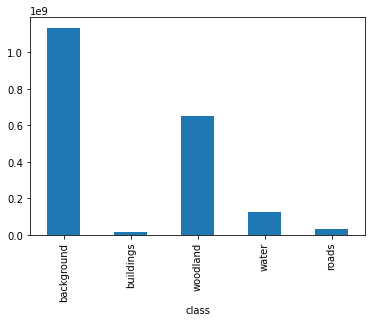

In [10]:
# create dict with already calculated values to bypass renewed calculating

class_count = {
     0: 1134439928.0, 
     1: 16767238.0, 
     2: 648714832.0, 
     3: 126508305.0, 
     4: 31785377.0
}

class_names = ['background', 'buildings', 'woodland', 'water', 'roads']

# column_mapper = {
#      0: 'background', 
#      1: 'buildings', 
#      2: 'woodland', 
#      3: 'water', 
#      4: 'roads'
# }

df = pd.DataFrame(data=class_count.items(), 
                  index=class_names, 
                  columns=['class_number', 'pixel_count'])

df.loc[:, 'pixel_count'].plot.bar()
plt.xlabel('class')

df

In [11]:
max(class_count, key=class_count.get)

0

In [12]:
class_count[0]

1134439928.0

In [13]:
def get_class_weight(dictionary):
    
    id_max_val = max(dictionary, key=dictionary.get)
    max_val = dictionary[id_max_val]
    
    for key in dictionary:
        dictionary[key] = max_val / dictionary[key]
        
    return dictionary

In [14]:
class_weight = get_class_weight(class_count)
class_weight

{0: 1.0,
 1: 67.65812759382314,
 2: 1.7487497927286484,
 3: 8.967315845390546,
 4: 35.690623647471604}

# Build DeepLabv3+ and load weights

https://keras.io/examples/vision/deeplabv3_plus/

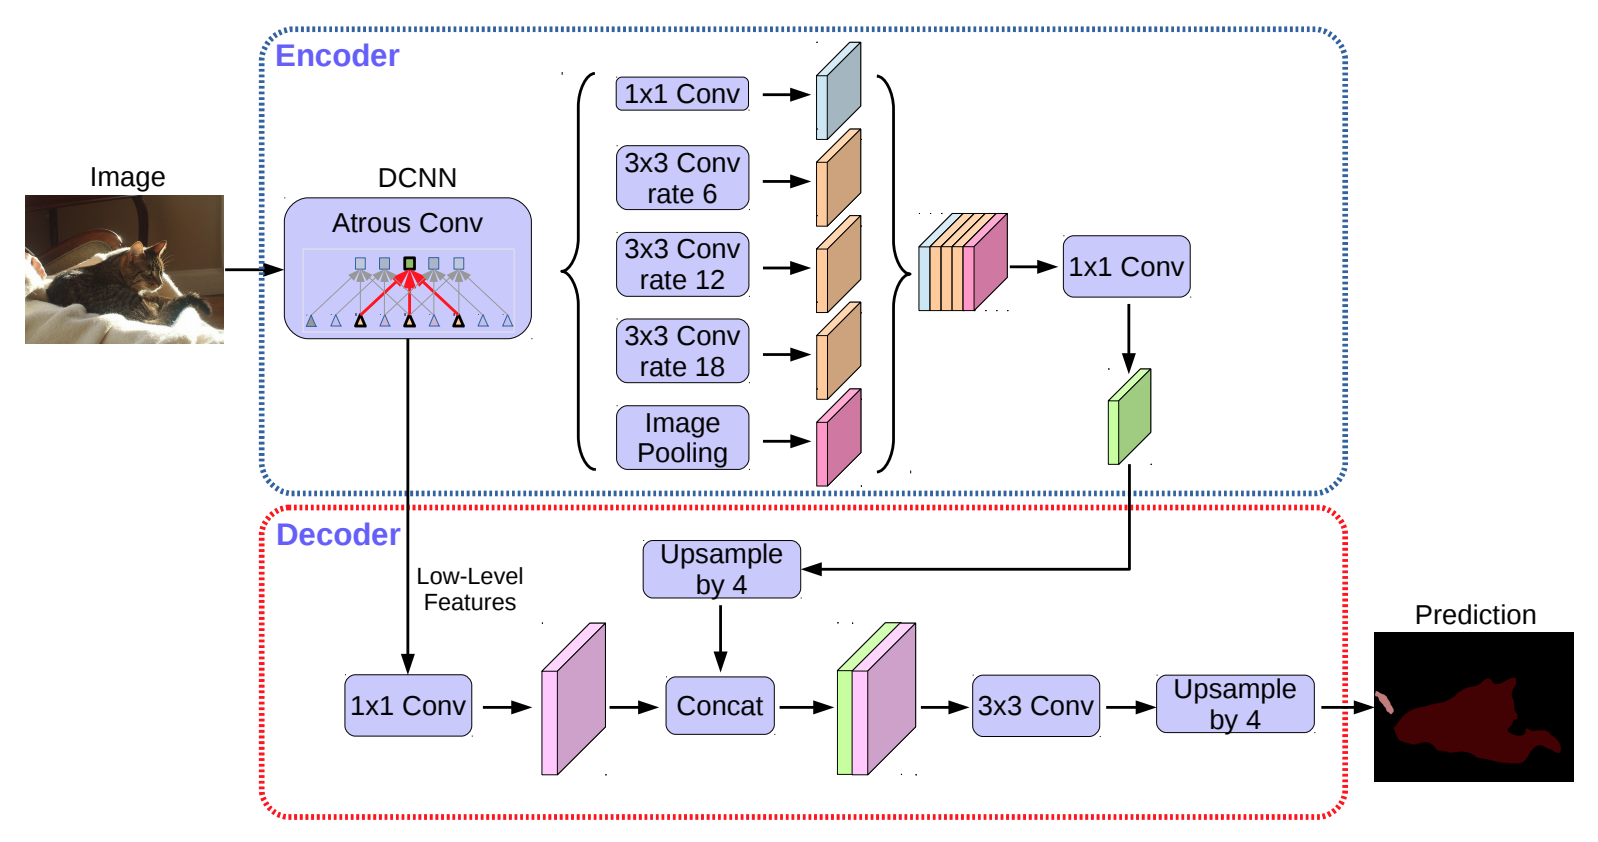

In [15]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [16]:
# xception = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(515,515,3))

# xception.trainable = False

In [17]:
# xception.summary()

In [18]:
# resnet50 = tf.keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_shape=(512, 512, 3))

# resnet50.summary()

In [19]:
def DeeplabV3Plus(img_size, num_classes):
    model_input = tf.keras.Input(shape=(img_size, img_size, 3))
    
#     resnet50 = tf.keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_tensor=model_input
#     )
    
#     x = resnet50.get_layer("conv4_block6_2_relu").output

    xception = tf.keras.applications.Xception(
        include_top=False, weights='imagenet', input_tensor=model_input)
    
    xception.trainable = False
    
    x = xception.get_layer('block13_sepconv2_bn').output
    
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(img_size // 4 // x.shape[1], img_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
#     input_b = resnext50.get_layer("conv2_block3_2_relu").output
    input_b = xception.get_layer("block3_sepconv2_act").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(img_size // x.shape[1], img_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 515, 515, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 257, 257, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 257, 257, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 257, 257, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [20]:
# callbacks

def get_best_weights_callback(filepath):
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch')

    return checkpoint_callback

In [21]:
checkpoint_path = abs_path + '/notebooks/exploratory/results/DeepLabv3+/5.3_class_weights_no_aug/best_weights'
dir_path = abs_path + '/notebooks/exploratory/results/DeepLabv3+/5.3_class_weights_no_aug'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [22]:
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

best_val_acc = get_best_weights_callback(checkpoint_path)

In [23]:
# def mIOU(mask_predicted, mask_original):
    
#     m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
#     mask_original = mask_original[..., 0]
     
#     m.update_state([mask_original], [mask_predicted])
        
#     return m.result()

In [24]:
loss_weights = list(class_weight.values())

Epoch 1/15
3735/3735 [==============================] - 507s 134ms/step - loss: 0.4736 - accuracy: 0.8293 - val_loss: 0.7996 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71865, saving model to /home/marcin/git_workspace/Semantic-segmentation-for-LandCover.ai-dataset/notebooks/exploratory/results/DeepLabv3+/5.3_class_weights_no_aug/best_weights
Epoch 2/15
3735/3735 [==============================] - 503s 135ms/step - loss: 0.3064 - accuracy: 0.8931 - val_loss: 0.6210 - val_accuracy: 0.7781

Epoch 00002: val_accuracy improved from 0.71865 to 0.77808, saving model to /home/marcin/git_workspace/Semantic-segmentation-for-LandCover.ai-dataset/notebooks/exploratory/results/DeepLabv3+/5.3_class_weights_no_aug/best_weights
Epoch 3/15
3735/3735 [==============================] - 503s 135ms/step - loss: 0.2435 - accuracy: 0.9132 - val_loss: 0.5750 - val_accuracy: 0.7969

Epoch 00003: val_accuracy improved from 0.77808 to 0.79694, saving model to /home/marcin/git_works

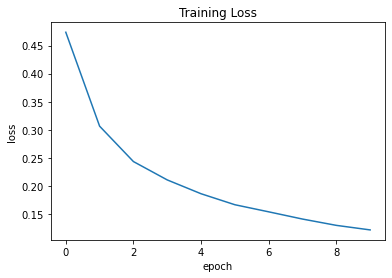

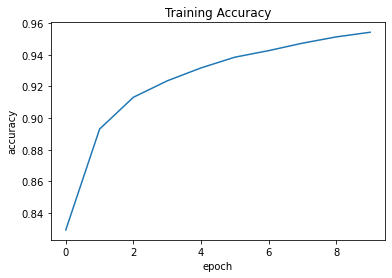

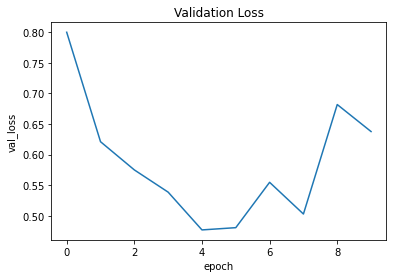

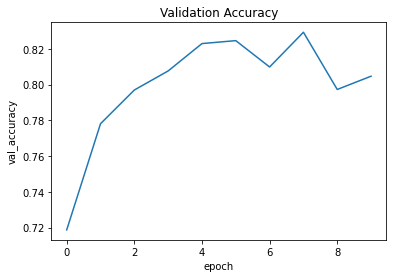

In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
    loss_weights=loss_weights
)

history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=15,
                   callbacks=[early_stopping_val_loss,
                             best_val_acc]
                   )

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


In [26]:
model.load_weights(checkpoint_path)

In [27]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    image = tf.image.resize(image, [512, 512])
    image.set_shape([None, None, 3])
    image = tf.reshape(image, (512,512,3))
    overlay = tfa.image.blend(image, colored_mask, 0.5)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, masks_list, colormap, model):
    for image_file, mask_file in zip(images_list, masks_list):
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]
        mask_tensor = decode_segmentation_masks(mask_tensor, colormap, NUM_CLASSES)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        overlay_orginal = get_overlay(image_tensor, mask_tensor)
        plot_samples_matplotlib(
            [image_tensor, overlay_orginal, overlay, prediction_colormap], figsize=(18, 14)
        )


In [28]:
colormap = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

In [29]:
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))
test_dataset = data_generator(test_images, test_masks)

print("Test Dataset:", test_dataset)

Test Dataset: <BatchDataset shapes: ((2, 515, 515, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


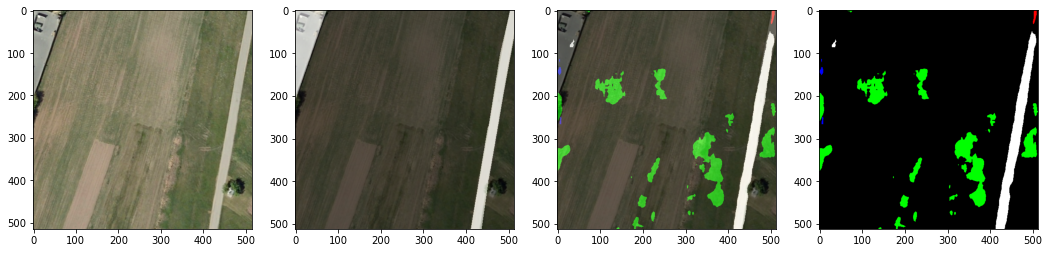

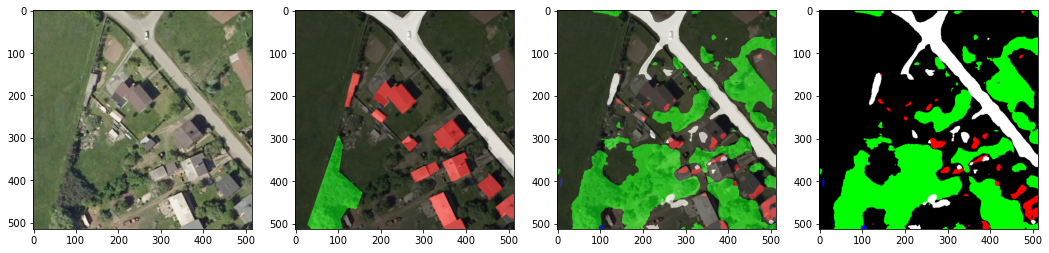

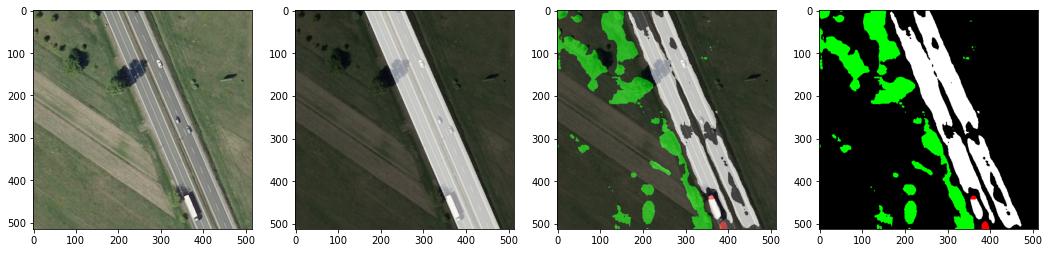

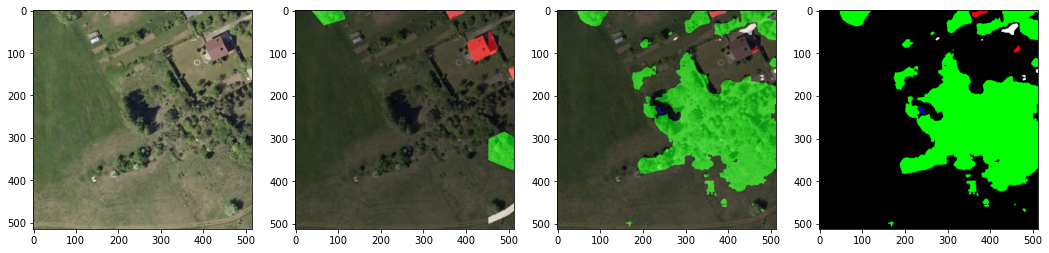

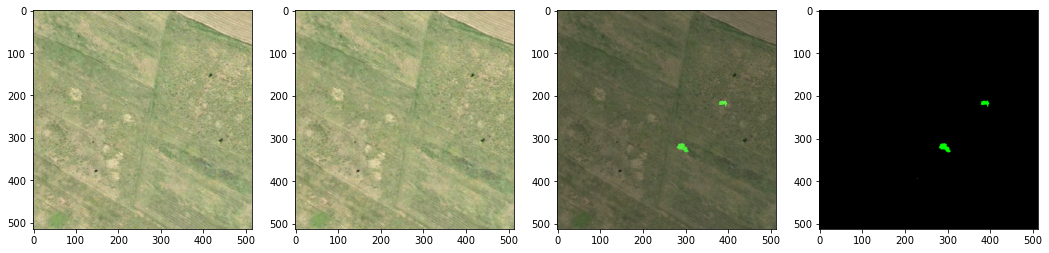

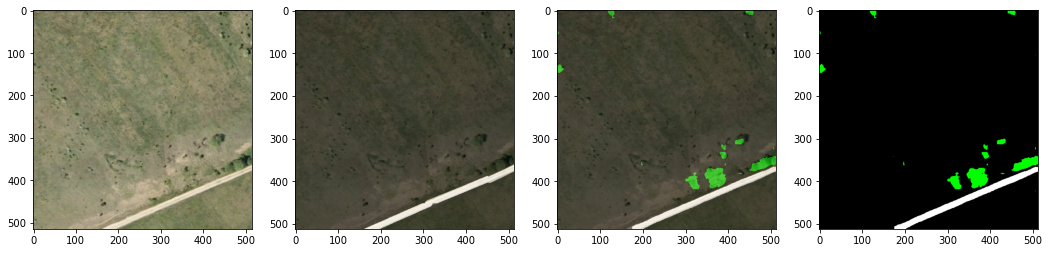

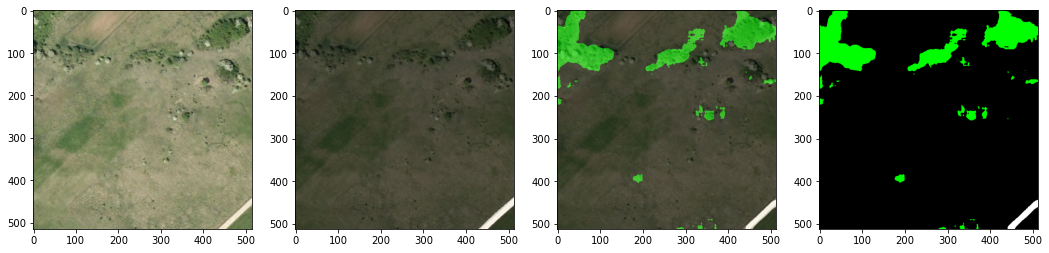

In [30]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range], test_masks[left_range:right_range] , colormap, model=model)

## mIOU metric

In [31]:
def get_miou_for_images(images_list, masks_list):
    
    m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
    for image_file, mask_file in zip(images_list, masks_list):
        
        image_tensor = read_image(image_file)
        
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        m.update_state([mask_tensor], [prediction_mask])
        
    return m.result().numpy()

In [32]:
get_miou_for_images(test_images, test_masks)

0.517444